In [123]:
# ALL Imports
import torch
from torch import nn
# import torchmetrics
# from torchmetrics.classification import AUROC
from sklearn import metrics

import statistics
import pandas as pd
import numpy as np 

import matplotlib.pyplot as plt
import seaborn as sns

In [124]:
# plot test AUC, Brier Loss and Precision Score
def plot_auc(prediction, target, title):
    avg_precision = metrics.average_precision_score(target, prediction)
    print('Average Precision Score:', avg_precision)
    brier_loss = metrics.brier_score_loss(target, prediction)
    print('Brier Loss:', brier_loss)
    auc = metrics.roc_auc_score(target, prediction)
    fp, tp, thresolds = metrics.roc_curve(target, prediction)
    # print('True Positives:', statistics.mean(tp))
    # print('False Positives:', statistics.mean(fp))
    plt.figure(figsize=(5, 5))
    plt.axis('scaled')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    # plot ROC
    plt.plot(fp, tp, color='cornflowerblue', alpha=0.5)
    # plot AUC
    plt.fill_between(fp, tp,  facecolor='lightskyblue', alpha=0.5)
    plt.text(0.95, 0.05, 'AUC = %0.2f' % auc, ha='right', weight='bold', color='cornflowerblue')
    plt.xlabel("False Positive Rate (FP)")
    plt.ylabel("True Positive Rate (TP)")
    plt.title(title)
    plt.show()

# plot training and testing loss
def plot_loss(loss, y_ticks, x_ticks, y_label, x_label, title, hist = False):
    plt.figure().set_figwidth(10)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.yticks(y_ticks)
    plt.legend(["Model Loss"], loc = 'upper right')
    if hist: 
        sns.histplot(loss, legend=True)
    else:
        plt.plot([(_+1) for _ in range(x_ticks)], loss)
    plt.show()

In [125]:
# DATASET ----------------------------------------------------------------------------------------------------------
# final dataset format: 
#         - the input file contains the list of SNPs per sample ID [columns 1-147], and PHENO value per sample [last column] 
class GeneticData(torch.utils.data.Dataset):
    """ Dataset for Genomic Variants Data """

    def __init__(self, file):
        """ Args --> file (String) = Directory to the .txt file with the data
        """
        self.data = pd.read_csv(file)
        self.num_mutations = self.data.shape[1] - 2
        self.samples = self.data['SAMPLE']
        cols = self.data.columns.tolist()
        self.genotypes = self.data.loc[:, cols[1]:cols[self.num_mutations]]
        self.phenotypes = self.data[cols[self.num_mutations+1]]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        sample = str(self.samples.iloc[index])
        x = self.genotypes.iloc[index].tolist()
        x_gt = [g.split('/') for g in x] # only for the 1million dataset subsets
        x = [(int(g[0])+int(g[1])) for g in x_gt] # only for the 1million dataset subsets
        x = torch.tensor(np.float32(x))
        y = self.phenotypes.iloc[index].tolist()
        y = torch.tensor(np.float32(y))
        return (sample, x, y)
    

In [172]:
# MODEL -----------------------------------------------------------------------------------------------------------
class CrohnsPred(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.input_size = input_size

        # input layer ---------------------[ input size: num_mutations = 140 --> input size: num_mutations = 140 ] 
        self.input_layer = nn.Linear(input_size, input_size)
        # (8) hidden layers ------------[ input size: num_mutations --> output size: CD snps = 140 (h1), chromosome pairs = 22* (h2) ] 
        self.hidden1 = nn.Linear(input_size, input_size)
        self.hidden2 = nn.Linear(input_size, input_size)
        self.hidden3 = nn.Linear(input_size, input_size)
        self.hidden4 = nn.Linear(input_size, input_size)
        self.hidden5 = nn.Linear(input_size, input_size)
        self.hidden6 = nn.Linear(input_size, input_size)
        self.hidden7 = nn.Linear(input_size, input_size)
        self.hidden8 = nn.Linear(input_size, input_size)
        self.hidden9 = nn.Linear(input_size, input_size)
        self.hidden10 = nn.Linear(input_size, 22)
        self.hidden11 = nn.Linear(22, 22)
        self.hidden12 = nn.Linear(22, 22)
        self.hidden13 = nn.Linear(22, 22)
        self.hidden14 = nn.Linear(22, 22)
        self.hidden15 = nn.Linear(22, 22)
        self.hidden16 = nn.Linear(22, 22)
        self.hidden17 = nn.Linear(22, 22)
        self.hidden18 = nn.Linear(22, 22)
        self.hidden19 = nn.Linear(22, 22)
        self.hidden20 = nn.Linear(22, 22)
        self.output_layer = nn.Linear(22, 1) # output layer -----[ input size: 4 --> output size: prediction score = 1 ] 

        self.dropout = nn.Dropout(p=0.1) # dropout layer
        # activation functions #
        self.relu = nn.PReLU(1)  # for hidden layers 
        self.sigmoid = nn.Sigmoid()  # for output layer 

    # model forward pass flow
    def forward(self, x):
        # PReLU activation for input and hidden layers #
        x = self.relu(self.input_layer(x)) 
        x = self.relu(self.hidden1(x)) 
        x = self.relu(self.hidden2(x)) 
        x = self.relu(self.hidden3(x)) 
        x = self.relu(self.hidden4(x))
        x = self.relu(self.hidden5(x)) 
        x = self.relu(self.hidden6(x)) 
        x = self.relu(self.hidden7(x)) 
        x = self.relu(self.hidden8(x)) 
        x = self.relu(self.hidden9(x)) 
        x = self.dropout(x)   # dropout layer
        x = self.relu(self.hidden10(x)) 
        x = self.relu(self.hidden11(x)) 
        x = self.relu(self.hidden12(x)) 
        x = self.relu(self.hidden13(x)) 
        x = self.relu(self.hidden14(x)) 
        x = self.relu(self.hidden15(x)) 
        x = self.relu(self.hidden16(x)) 
        x = self.relu(self.hidden17(x)) 
        x = self.relu(self.hidden18(x)) 
        x = self.relu(self.hidden19(x)) 
        x = self.relu(self.hidden20(x)) 
        x = self.output_layer(x)
        x = self.sigmoid(x) # squash output between 0 and 1
        return x
    
    def xavier_init(self, m):
        if type(m) == nn.Linear:
            torch.nn.init.xavier_uniform_(m.weight)


# Save Model after training is complete
def save_model(model):
    model_path = 'model/crohns_pred.pth'
    try:
        torch.save(model, model_path)
        print("Saved PyTorch Model State to", model_path)
    except:
        print("An error occurred.")

In [173]:
# 1. LOAD DATA ----------------------------------------------------------------------------------------------
# WARNING: not all the listed filepaths are available in this repository. 
# Please do not uncomment unavailable dataset paths.
# data_path = 'data/outputs/5k/1kSnps.txt'  # 5000 samples, 1187 SNPs -> Unavailable
# data_path = 'data/outputs/5k/2kSnps.txt'  # 5000 samples, 2075 SNPs
# data_path = 'data/outputs/1mil/5k.txt'    # 5000 samples, 147 SNPs
data_path = 'data/outputs/1mil/10k.txt'     # 10000 samples, 147 SNPs
# data_path = 'data/outputs/1mil/100k.txt'  # 100000 samples, 147 SNPs -> Unavailable
genomic_dataset = GeneticData(data_path)
sample_num = len(genomic_dataset)
# Set number of input mutations (i.e. input neurons): 147
num_mutations = genomic_dataset.num_mutations

# 2. INITIALIZE MODEL ----------------------------------------------------------------------------------------------
model = CrohnsPred(num_mutations)
model.apply(model.xavier_init)
print(model, "\nTotal samples:", sample_num)

CrohnsPred(
  (input_layer): Linear(in_features=147, out_features=147, bias=True)
  (hidden1): Linear(in_features=147, out_features=147, bias=True)
  (hidden2): Linear(in_features=147, out_features=147, bias=True)
  (hidden3): Linear(in_features=147, out_features=147, bias=True)
  (hidden4): Linear(in_features=147, out_features=147, bias=True)
  (hidden5): Linear(in_features=147, out_features=147, bias=True)
  (hidden6): Linear(in_features=147, out_features=147, bias=True)
  (hidden7): Linear(in_features=147, out_features=147, bias=True)
  (hidden8): Linear(in_features=147, out_features=147, bias=True)
  (hidden9): Linear(in_features=147, out_features=147, bias=True)
  (hidden10): Linear(in_features=147, out_features=22, bias=True)
  (hidden11): Linear(in_features=22, out_features=22, bias=True)
  (hidden12): Linear(in_features=22, out_features=22, bias=True)
  (hidden13): Linear(in_features=22, out_features=22, bias=True)
  (hidden14): Linear(in_features=22, out_features=22, bias=True

In [174]:
# 3. MODEL TRAINING ------------------------------------------------------------------------------------------------------
# load training data
# final training dataset format: 
#         - the input file contains the list of SNPs per sample ID [columns 1-147], and phenotype value {0,1} per sample [last column] 
#         - holdout: split the dataset into training [70%-60% of the entire dataset] and testing [30%-40% of the entire dataset]
train_size = int(0.6 * sample_num) # 60:40 split
test_size = len(genomic_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(genomic_dataset, [train_size, test_size]) # get training and test dataset as GeneticData instances
print("\nTrain dataset:", train_size, "samples")

# set epochs and batch size
epochs_num = 300
batch_size = 250
model_train_loss = [] # save model loss for each epoch

# set model parameters
model_optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Adam Optimizer
model_loss = nn.MSELoss()  # Mean Squared Error Loss
# model_loss = nn.BCELoss()  # Binary Cross Entropy Loss


dataloader_train = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# train model 
for epoch in range(epochs_num): 
    model.train()
    for i, (sample, x, y) in enumerate(dataloader_train):
        # inputs
        inputs = x
        # target outputs
        target = y.unsqueeze(1) # to match model output shape [batch_size, 1]

        # model outputs
        output = model(inputs) 
        loss = model_loss(output, target)  # compute loss

        # step + optimizer
        model_optimizer.zero_grad()  
        loss.backward()
        model_optimizer.step()

    model_train_loss.append(loss.item())
    
    if (epoch+1)%50 == 0:
        # Calculate the loss for this epoch
        print(f'Epoch {epoch+1}/{epochs_num}: --> Loss = {loss.item()}')

# save_model(model)


Train dataset: 6000 samples
Epoch 50/300: --> Loss = 0.005757723934948444
Epoch 100/300: --> Loss = 0.004301844164729118
Epoch 150/300: --> Loss = 0.012119481340050697
Epoch 200/300: --> Loss = 0.004000001586973667
Epoch 250/300: --> Loss = 0.0040000006556510925
Epoch 300/300: --> Loss = 0.004000000189989805


MSE mean test loss: 0.019


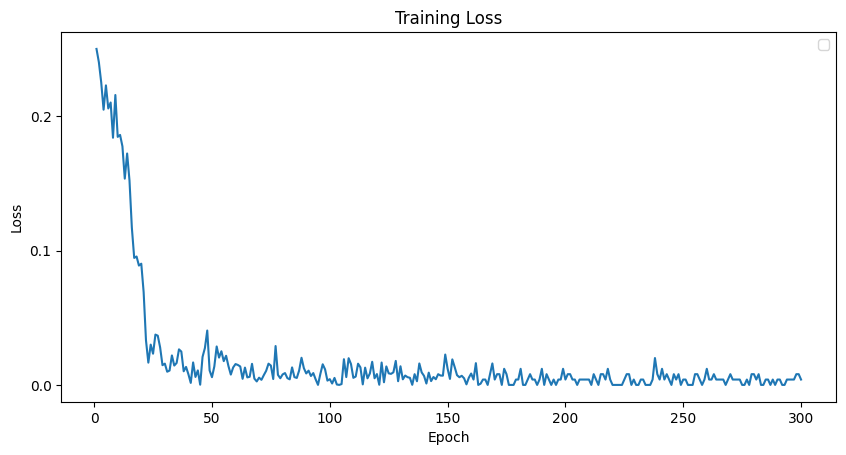

In [175]:
# 3. PLOT TRAINING LOSS ------------------------------------------------------------------------------------------------
print("MSE mean test loss:", '{:.3f}'.format(statistics.mean(model_train_loss)))
plot_loss(model_train_loss, np.linspace(0,1,11) , epochs_num, "Loss", "Epoch", "Training Loss")
# plot_loss(model_train_loss, np.linspace(1,110,11), np.linspace(0,0.5,11), "Samples", "Loss", "Training Loss Distribution", hist=True)

In [176]:
# 4. TEST MODEL ------------------------------------------------------------------------------------------------
print("Testing dataset:", test_size, "samples")
# load testing data
# final testing dataset format: 
#         - test dataset was split from the original dataset [30%-40% of the entire dataset] 
dataloader_test = torch.utils.data.DataLoader(test_dataset, shuffle=True)
mse_loss = model_loss
# mae_loss = nn.L1Loss()

# for evaluation
model_eval_loss = [] # save model loss for each test
eval_samples = [] # save test samples
eval_target = [] # save test targets
eval_pred = [] # save test model predictions

with torch.no_grad(): # don't track grad
    model.eval()
    for i, (sample,x,y) in enumerate(dataloader_test):
        # inputs
        inputs = x
        # target outputs
        target = y.unsqueeze(1)
        output = model(inputs)

        # compute loss
        model_eval_loss.append(float(mse_loss(output, target))) # Mean Squared Error
        eval_samples.append(sample)
        eval_pred.append(output)
        eval_target.append(target)


Testing dataset: 4000 samples


Average Precision Score: 0.6079969106489169
Brier Loss: 0.37693858250617474


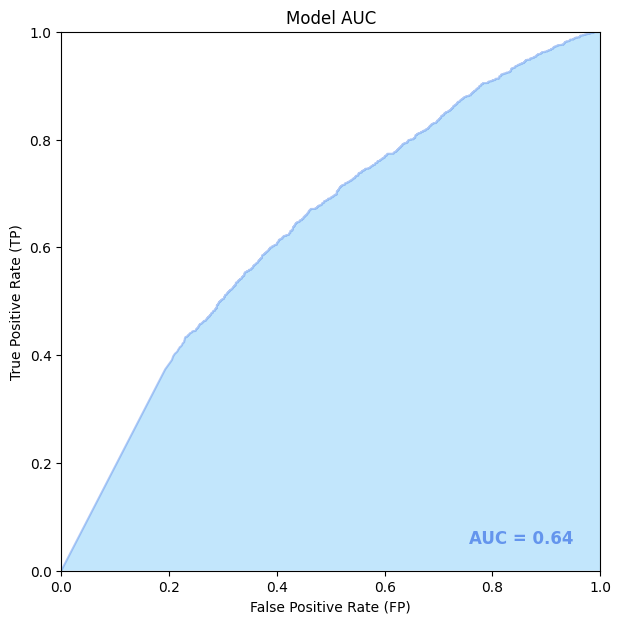

In [227]:
# 5. PLOT TEST ------------------------------------------------------------------------------------------------
target = torch.tensor(eval_target)
predictions =torch.tensor(eval_pred)

plot_auc(torch.Tensor.numpy(predictions), torch.Tensor.numpy(target), "Model AUC")

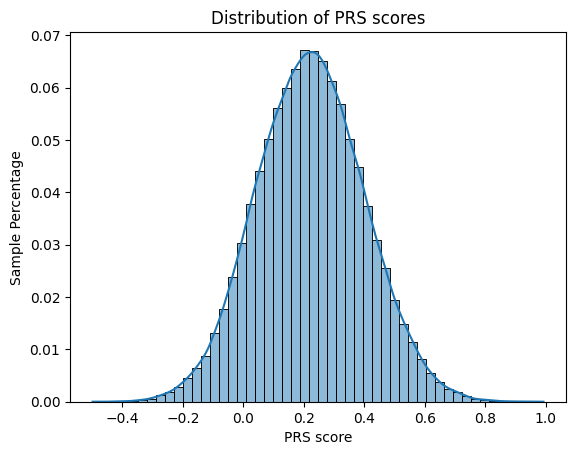

In [211]:
# Plot population PRS distribution to choose threshold
ds = pd.read_csv('data/outputs/1mil/per_sample_prs.txt')
prs_dist = list(ds['PRS'])
sns.histplot(prs_dist, bins=50, kde=True, stat='probability')
plt.xlabel('PRS score')
plt.ylabel('Sample Percentage')
plt.title("Distribution of PRS scores")
plt.show()

In [216]:
# Compare Model vs PRS Performance
all_file = pd.read_csv('data/outputs/1mil/10k.txt')

# turn model predictions into list
model_test_pred = []
for val in eval_pred:
    val = float(val)
    model_test_pred.append(val)

# track all phenotypes of test samples
pheno = {}
data = []
i = 0
for name in eval_samples:
    n = list(name)[0]
    data.append({'SAMPLE': n, 'MODEL': ('{:.3f}'.format(model_test_pred[i]))})
    i += 1
model_data = pd.DataFrame(data)
# model_data.head()


conf = []
perfect_model_preds = 0
threshold = 0.1
for sample in list(model_data['SAMPLE']):
    pheno = float(list(all_file[all_file['SAMPLE']==sample]['PHENO'])[0]) # get phenotype
    prs = float(list(ds[ds['SAMPLE'] == sample]['PRS'])[0]) # get manual prs
    if prs >= 0.4 : prs = 1.0 # apply thresholding
    else: prs = 0.0
    m = float(list(model_data[model_data['SAMPLE'] == sample]['MODEL'])[0]) # get model prediction
    acc = ''
    # check which prediction/score is closer to actual phenotype
    if abs(pheno-m) <= threshold: perfect_model_preds+=1
    if abs(pheno-prs) < abs(pheno-m): acc = 'PRS'
    elif abs(pheno-prs) > abs(pheno-m): acc = 'Model'
    else: acc = 'Equal' # if they're the same
    conf.append({'SAMPLE': sample, 'PHENO': pheno, 'PRS': prs, 'MODEL': m, 'ACC': acc})

final = pd.DataFrame(conf)
final.set_index('SAMPLE', inplace=True)
# final.to_csv('data/outputs/1mil/test_model_vs_prs.txt')

mod = final[final['ACC'] == 'Model'].count()
p = final[final['ACC'] == 'PRS'].count()
equal = final[final['ACC'] == 'Equal'].count()
print(f'\n{perfect_model_preds} Perfect Model predictions with threshold {threshold}. \n{mod['ACC']} more accurate model predictions. \n{p['ACC']} more accurate PRS predictions. \n{equal['ACC']} Equally accurate predictions.')

final.head()


2240 Perfect Model predictions with threshold 0.1. 
1488 more accurate model predictions. 
1121 more accurate PRS predictions. 
1391 Equally accurate predictions.


,PHENO,PRS,MODEL,ACC
SAMPLE,,,,
syn510526_syn510526,0.0,0.0,1.0,PRS
syn508745_syn508745,0.0,0.0,0.0,Equal
syn509319_syn509319,0.0,0.0,0.0,Equal
syn513071_syn513071,1.0,0.0,0.0,Equal
syn507415_syn507415,1.0,0.0,1.0,Model


In [219]:
# check performance on a case-control level
controls = final[final['PHENO'] == 0] 
cases = final[final['PHENO'] == 1]
print(f'Model is more accurate than PRS in {(cases[cases['ACC'] == 'Model'].count()['ACC'] / len(cases))*100}% of cases.')
print(f'Model is more accurate than PRS in {(controls[controls['ACC'] == 'Model'].count()['ACC'] / len(controls))*100}% of controls.')
print(f'Predictions are equal in {(cases[cases['ACC'] == 'Equal'].count()['ACC'] / len(cases))*100}% of cases.')
print(f'Predictions are equal in {(controls[controls['ACC'] == 'Equal'].count()['ACC'] / len(controls))*100}% of controls.')

Model is more accurate than PRS in 62.88451840645487% of cases.
Model is more accurate than PRS in 11.948438274665344% of controls.
Predictions are equal in 28.946041351487644% of cases.
Predictions are equal in 40.505701536936044% of controls.


Average Precision Score: 0.4930219924917353
Brier Loss: 0.50275


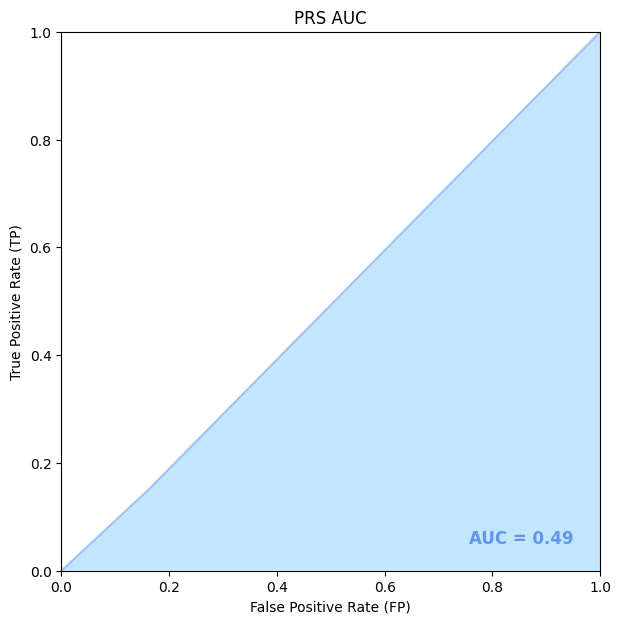

In [228]:
prs_dist = list(final['PRS'])

target = torch.Tensor.numpy(torch.tensor(eval_target))
predictions = torch.Tensor.numpy(torch.tensor(prs_dist))
plot_auc(predictions, target, "PRS AUC")

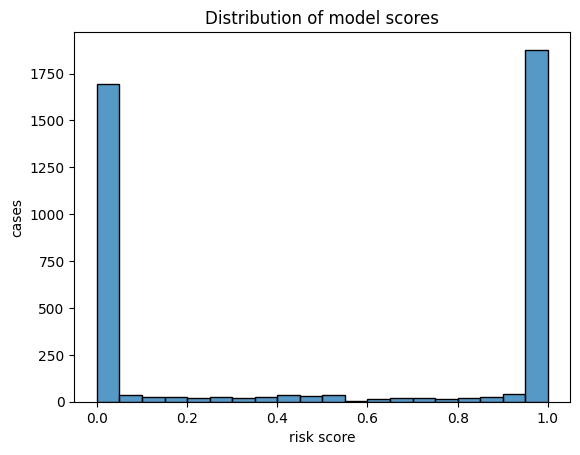

In [229]:
sns.histplot(model_test_pred, bins=20)
plt.xlabel('risk score')
plt.ylabel('cases')
plt.title("Distribution of model scores")
plt.show()

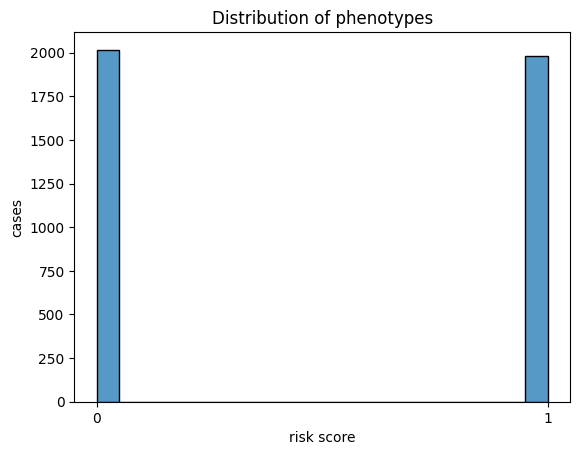

In [230]:
pheno_dist = list(final['PHENO'])
sns.histplot(pheno_dist, bins=20)
plt.xlabel('risk score')
plt.xticks([0,1])
plt.ylabel('cases')
plt.title("Distribution of phenotypes")
plt.show()

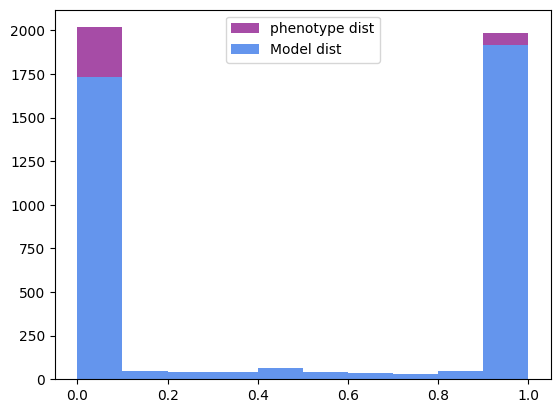

In [231]:
# plt.hist(prs_dist, label='weighted PRS')
plt.hist(pheno_dist, color='purple', label='phenotype dist', alpha=0.7)
plt.hist(model_test_pred, color='cornflowerblue', label='Model dist')

plt.legend()
plt.show()